# 近傍物件数の分析

人口・需要の代理変数として「近傍物件数」が予測精度改善に効くか検証する。

In [1]:
import sys
from pathlib import Path

# プロジェクトルートをパスに追加
project_root = Path.cwd().parents[2]
if str(project_root / '04_src') not in sys.path:
    sys.path.insert(0, str(project_root / '04_src'))

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from data.loader import DataLoader

# 日本語フォント設定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# データ読み込み
data_config_path = project_root / '03_configs' / 'data.yaml'
with open(data_config_path, 'r') as f:
    data_config = yaml.safe_load(f)

data_config['data']['train_path'] = str(project_root / data_config['data']['train_path'])
data_config['data']['test_path'] = str(project_root / data_config['data']['test_path'])
data_config['data']['sample_submit_path'] = str(project_root / data_config['data']['sample_submit_path'])

loader = DataLoader(config=data_config, add_address_columns=False)
train = loader.load_train()

# OOF予測
exp_dir = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
oof_path = list((exp_dir / 'outputs').glob('run_huber_*/oof_predictions.csv'))[0]
oof_df = pl.read_csv(oof_path)
actual = oof_df['actual'].to_numpy()
pred = oof_df['predicted'].to_numpy()
ape = np.abs(actual - pred) / actual * 100

print(f'Train shape: {train.shape}')
print(f'Mean APE: {np.mean(ape):.2f}%')

Train shape: (363924, 149)
Mean APE: 12.17%


## 1. サンプル数は人口に比例しているか？

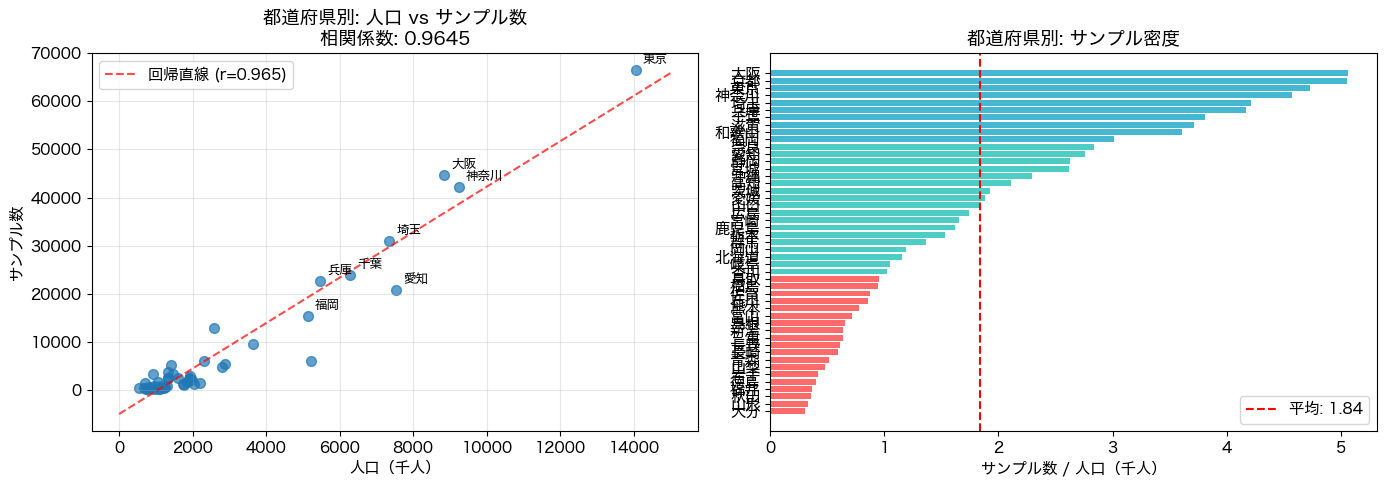


=== 結論 ===
サンプル数 vs 人口の相関: 0.9645
→ サンプル数は人口にほぼ比例している
→ サンプル数自体が需要（人口）の代理変数として使える


In [2]:
# 都道府県別集計
pref_counts = train.group_by('addr1_1').agg(pl.len().alias('sample_count')).sort('addr1_1')

# 2020年国勢調査の人口（千人）
population_2020 = {
    1: 5224, 2: 1238, 3: 1227, 4: 2302, 5: 960, 6: 1068, 7: 1834,
    8: 2868, 9: 1934, 10: 1939, 11: 7345, 12: 6284, 13: 14048, 14: 9237,
    15: 2201, 16: 1035, 17: 1133, 18: 767, 19: 810, 20: 2048, 21: 1979,
    22: 3635, 23: 7542, 24: 1771, 25: 1414, 26: 2578, 27: 8838, 28: 5466,
    29: 1324, 30: 923, 31: 553, 32: 671, 33: 1888, 34: 2800, 35: 1343,
    36: 720, 37: 956, 38: 1335, 39: 692, 40: 5135, 41: 812, 42: 1312,
    43: 1739, 44: 1124, 45: 1070, 46: 1588, 47: 1468,
}

pref_names = {
    1: '北海道', 2: '青森', 3: '岩手', 4: '宮城', 5: '秋田', 6: '山形', 7: '福島',
    8: '茨城', 9: '栃木', 10: '群馬', 11: '埼玉', 12: '千葉', 13: '東京', 14: '神奈川',
    15: '新潟', 16: '富山', 17: '石川', 18: '福井', 19: '山梨', 20: '長野', 21: '岐阜',
    22: '静岡', 23: '愛知', 24: '三重', 25: '滋賀', 26: '京都', 27: '大阪', 28: '兵庫',
    29: '奈良', 30: '和歌山', 31: '鳥取', 32: '島根', 33: '岡山', 34: '広島', 35: '山口',
    36: '徳島', 37: '香川', 38: '愛媛', 39: '高知', 40: '福岡', 41: '佐賀', 42: '長崎',
    43: '熊本', 44: '大分', 45: '宮崎', 46: '鹿児島', 47: '沖縄',
}

# DataFrameに変換
pref_df = pref_counts.to_pandas()
pref_df['population'] = pref_df['addr1_1'].map(population_2020)
pref_df['pref_name'] = pref_df['addr1_1'].map(pref_names)
pref_df = pref_df.dropna()

# 相関計算
corr = np.corrcoef(pref_df['sample_count'], pref_df['population'])[0, 1]

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 散布図
ax = axes[0]
ax.scatter(pref_df['population'], pref_df['sample_count'], alpha=0.7, s=50)

# 主要都道府県にラベル
for _, row in pref_df.iterrows():
    if row['sample_count'] > 15000 or row['population'] > 8000:
        ax.annotate(row['pref_name'], (row['population'], row['sample_count']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)

# 回帰直線
z = np.polyfit(pref_df['population'], pref_df['sample_count'], 1)
p = np.poly1d(z)
x_line = np.linspace(0, 15000, 100)
ax.plot(x_line, p(x_line), 'r--', alpha=0.7, label=f'回帰直線 (r={corr:.3f})')

ax.set_xlabel('人口（千人）')
ax.set_ylabel('サンプル数')
ax.set_title(f'都道府県別: 人口 vs サンプル数\n相関係数: {corr:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

# 右: サンプル/人口比の分布
ax = axes[1]
pref_df['ratio'] = pref_df['sample_count'] / pref_df['population']
pref_df_sorted = pref_df.sort_values('ratio', ascending=True)

colors = ['#ff6b6b' if r < 1 else '#4ecdc4' if r < 3 else '#45b7d1' for r in pref_df_sorted['ratio']]
ax.barh(pref_df_sorted['pref_name'], pref_df_sorted['ratio'], color=colors)
ax.axvline(pref_df['ratio'].mean(), color='red', linestyle='--', label=f'平均: {pref_df["ratio"].mean():.2f}')
ax.set_xlabel('サンプル数 / 人口（千人）')
ax.set_title('都道府県別: サンプル密度')
ax.legend()

plt.tight_layout()
plt.show()

print(f'\n=== 結論 ===')
print(f'サンプル数 vs 人口の相関: {corr:.4f}')
print(f'→ サンプル数は人口にほぼ比例している')
print(f'→ サンプル数自体が需要（人口）の代理変数として使える')

## 2. 郵便番号内物件数の分布

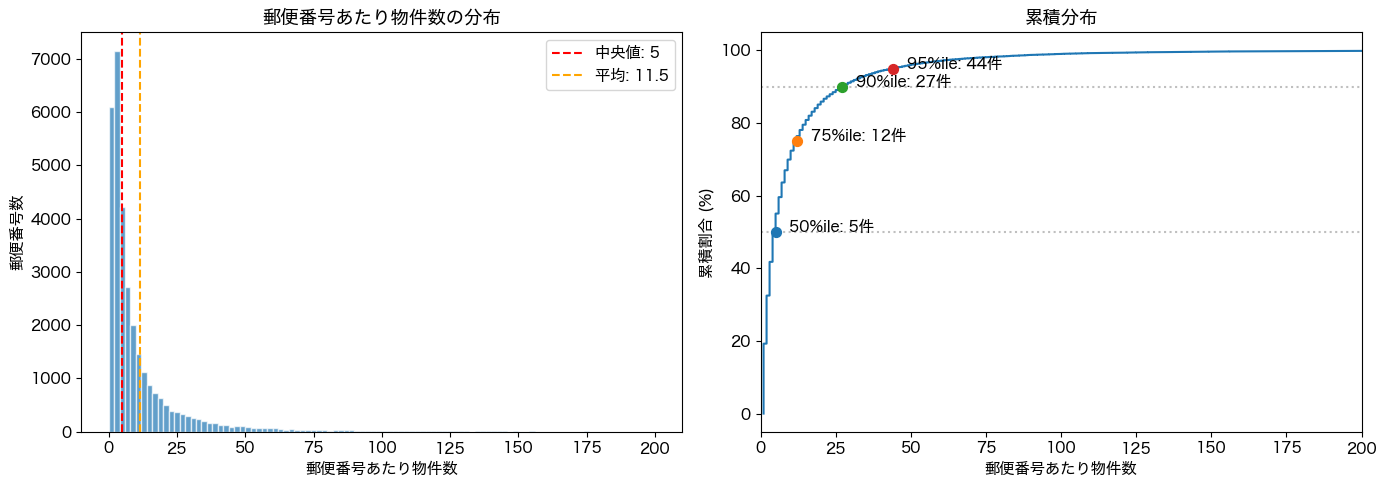


=== 統計 ===
ユニーク郵便番号: 31,691
物件数: Min=1, Max=8,172, Mean=11.5, Median=5


In [3]:
# 郵便番号を7桁に結合
train = train.with_columns([
    (pl.col('post1').cast(pl.Utf8) + pl.col('post2').cast(pl.Utf8).str.zfill(4)).alias('post_full')
])

# 郵便番号あたりの物件数
post_counts = train.group_by('post_full').agg(pl.len().alias('post_count'))
train = train.join(post_counts, on='post_full', how='left')
post_count = train['post_count'].fill_null(0).to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 郵便番号あたり物件数の分布
ax = axes[0]
counts = post_counts['post_count'].to_numpy()
ax.hist(counts, bins=100, range=(0, 200), edgecolor='white', alpha=0.7)
ax.axvline(np.median(counts), color='red', linestyle='--', label=f'中央値: {np.median(counts):.0f}')
ax.axvline(np.mean(counts), color='orange', linestyle='--', label=f'平均: {np.mean(counts):.1f}')
ax.set_xlabel('郵便番号あたり物件数')
ax.set_ylabel('郵便番号数')
ax.set_title('郵便番号あたり物件数の分布')
ax.legend()

# 右: 累積分布
ax = axes[1]
sorted_counts = np.sort(counts)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
ax.plot(sorted_counts, cumulative)
ax.axhline(50, color='gray', linestyle=':', alpha=0.5)
ax.axhline(90, color='gray', linestyle=':', alpha=0.5)

for p in [50, 75, 90, 95]:
    val = np.percentile(counts, p)
    ax.scatter([val], [p], s=50, zorder=5)
    ax.annotate(f'{p}%ile: {val:.0f}件', (val, p), textcoords='offset points', xytext=(10, 0))

ax.set_xlabel('郵便番号あたり物件数')
ax.set_ylabel('累積割合 (%)')
ax.set_title('累積分布')
ax.set_xlim(0, 200)

plt.tight_layout()
plt.show()

print(f'\n=== 統計 ===')
print(f'ユニーク郵便番号: {len(post_counts):,}')
print(f'物件数: Min={np.min(counts)}, Max={np.max(counts):,}, Mean={np.mean(counts):.1f}, Median={np.median(counts):.0f}')

## 3. 郵便番号内物件数 vs 予測誤差

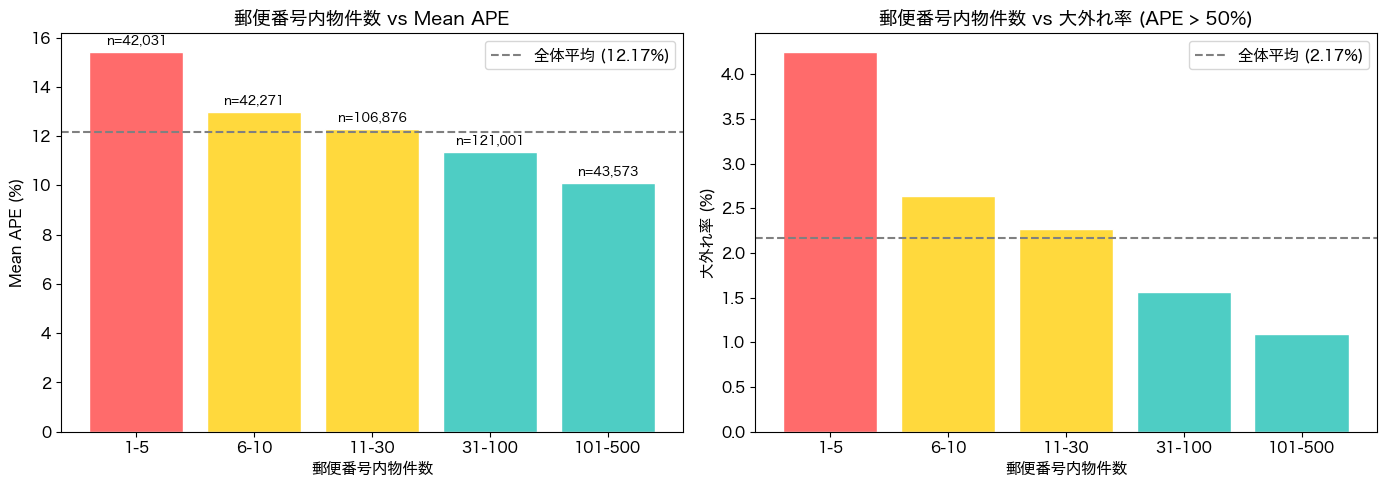


=== 郵便番号内物件数 vs 予測誤差 ===
       物件数 |        N |   Mean APE |       大外れ率
--------------------------------------------------
       1-5 |   42,031 |      15.4% |       4.2%
      6-10 |   42,271 |      13.0% |       2.6%
     11-30 |  106,876 |      12.3% |       2.3%
    31-100 |  121,001 |      11.3% |       1.6%
   101-500 |   43,573 |      10.1% |       1.1%

→ 物件数が少ない地域ほど予測誤差が大きい


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 物件数で分割
bins = [0, 5, 10, 30, 100, 500, 10000]
labels = ['1-5', '6-10', '11-30', '31-100', '101-500', '500+']

stats = []
for i in range(len(bins) - 1):
    mask = (post_count > bins[i]) & (post_count <= bins[i+1])
    n = np.sum(mask)
    if n > 0:
        stats.append({
            'label': labels[i],
            'n': n,
            'mean_ape': np.mean(ape[mask]),
            'large_rate': np.sum(ape[mask] > 50) / n * 100,
        })

# 左: Mean APE
ax = axes[0]
x = [s['label'] for s in stats]
y = [s['mean_ape'] for s in stats]
colors = ['#ff6b6b' if v > 13 else '#ffd93d' if v > 12 else '#4ecdc4' for v in y]
bars = ax.bar(x, y, color=colors, edgecolor='white')
ax.axhline(12.17, color='gray', linestyle='--', label='全体平均 (12.17%)')
ax.set_xlabel('郵便番号内物件数')
ax.set_ylabel('Mean APE (%)')
ax.set_title('郵便番号内物件数 vs Mean APE')
ax.legend()

for bar, s in zip(bars, stats):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'n={s["n"]:,}', ha='center', va='bottom', fontsize=9)

# 右: 大外れ率
ax = axes[1]
y = [s['large_rate'] for s in stats]
colors = ['#ff6b6b' if v > 3 else '#ffd93d' if v > 2 else '#4ecdc4' for v in y]
bars = ax.bar(x, y, color=colors, edgecolor='white')
ax.axhline(2.17, color='gray', linestyle='--', label='全体平均 (2.17%)')
ax.set_xlabel('郵便番号内物件数')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('郵便番号内物件数 vs 大外れ率 (APE > 50%)')
ax.legend()

plt.tight_layout()
plt.show()

print('\n=== 郵便番号内物件数 vs 予測誤差 ===')
print(f'{"物件数":>10} | {"N":>8} | {"Mean APE":>10} | {"大外れ率":>10}')
print('-' * 50)
for s in stats:
    print(f'{s["label"]:>10} | {s["n"]:>8,} | {s["mean_ape"]:>9.1f}% | {s["large_rate"]:>9.1f}%')

print('\n→ 物件数が少ない地域ほど予測誤差が大きい')

## 4. 問題セグメント（低価格×広面積）での効果

=== 問題セグメント: 低価格(500-1000万) × 広面積(100㎡+) ===
該当件数: 8,185
全体に占める割合: 2.2%
このセグメントのMean APE: 27.9%
このセグメントの大外れ率: 17.4%


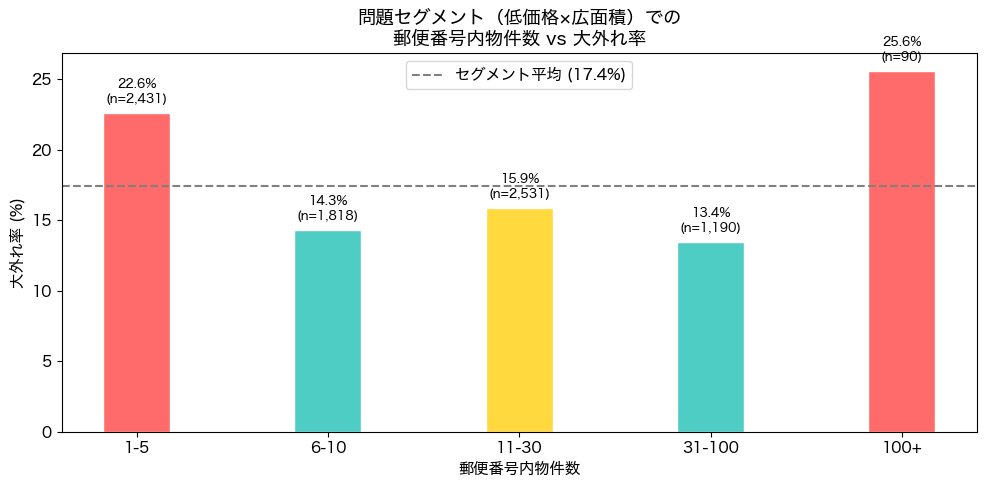


=== 問題セグメント内での物件数別分析 ===
       物件数 |      N |   Mean APE |       大外れ率
--------------------------------------------------
       1-5 |  2,431 |      32.9% |      22.6%
      6-10 |  1,818 |      25.1% |      14.3%
     11-30 |  2,531 |      25.8% |      15.9%
    31-100 |  1,190 |      24.7% |      13.4%
      100+ |     90 |      37.6% |      25.6%


In [5]:
house_area = train['house_area'].to_numpy()

# 低価格 & 広面積セグメント
low_price = (actual >= 5000000) & (actual < 10000000)
large_area = house_area >= 100
segment_mask = low_price & large_area

print(f'=== 問題セグメント: 低価格(500-1000万) × 広面積(100㎡+) ===')
print(f'該当件数: {np.sum(segment_mask):,}')
print(f'全体に占める割合: {np.sum(segment_mask)/len(actual)*100:.1f}%')
print(f'このセグメントのMean APE: {np.mean(ape[segment_mask]):.1f}%')
print(f'このセグメントの大外れ率: {np.sum(ape[segment_mask] > 50) / np.sum(segment_mask) * 100:.1f}%')

fig, ax = plt.subplots(figsize=(10, 5))

# このセグメント内での物件数別分析
bins = [0, 5, 10, 30, 100, 10000]
labels = ['1-5', '6-10', '11-30', '31-100', '100+']

segment_stats = []
for i in range(len(bins) - 1):
    mask = segment_mask & (post_count > bins[i]) & (post_count <= bins[i+1])
    n = np.sum(mask)
    if n > 0:
        segment_stats.append({
            'label': labels[i],
            'n': n,
            'mean_ape': np.mean(ape[mask]),
            'large_rate': np.sum(ape[mask] > 50) / n * 100,
        })

x = np.arange(len(segment_stats))
width = 0.35

# 大外れ率
large_rates = [s['large_rate'] for s in segment_stats]
colors = ['#ff6b6b' if v > 20 else '#ffd93d' if v > 15 else '#4ecdc4' for v in large_rates]
bars = ax.bar(x, large_rates, width, color=colors, edgecolor='white')

ax.set_xlabel('郵便番号内物件数')
ax.set_ylabel('大外れ率 (%)')
ax.set_title('問題セグメント（低価格×広面積）での\n郵便番号内物件数 vs 大外れ率')
ax.set_xticks(x)
ax.set_xticklabels([s['label'] for s in segment_stats])
ax.axhline(17.4, color='gray', linestyle='--', label='セグメント平均 (17.4%)')
ax.legend()

# 値を棒の上に表示
for bar, s in zip(bars, segment_stats):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{s["large_rate"]:.1f}%\n(n={s["n"]:,})', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print('\n=== 問題セグメント内での物件数別分析 ===')
print(f'{"物件数":>10} | {"N":>6} | {"Mean APE":>10} | {"大外れ率":>10}')
print('-' * 50)
for s in segment_stats:
    print(f'{s["label"]:>10} | {s["n"]:>6,} | {s["mean_ape"]:>9.1f}% | {s["large_rate"]:>9.1f}%')

## 5. 緯度経度ベースの近傍物件数（サンプリング分析）

In [6]:
lat = train['lat'].to_numpy()
lon = train['lon'].to_numpy()

print('=== 緯度経度ベースの近傍物件数計算 ===')
print(f'緯度範囲: {np.min(lat):.2f} ~ {np.max(lat):.2f}')
print(f'経度範囲: {np.min(lon):.2f} ~ {np.max(lon):.2f}')

# サンプリング（計算コスト削減）
np.random.seed(42)
sample_size = 10000
sample_idx = np.random.choice(len(train), sample_size, replace=False)

def count_nearby(lat_center, lon_center, lat_all, lon_all, radius_km):
    """指定半径内の物件数をカウント（簡易距離計算）"""
    lat_diff_km = (lat_all - lat_center) * 111  # 緯度1度≒111km
    lon_diff_km = (lon_all - lon_center) * 91   # 経度1度≒91km（日本）
    dist_km = np.sqrt(lat_diff_km**2 + lon_diff_km**2)
    return np.sum(dist_km <= radius_km)

# 半径1kmでの近傍物件数
print(f'\nサンプル数: {sample_size}')
print('近傍物件数を計算中...')

radius = 1.0
nearby_1km = np.zeros(sample_size)
for i, idx in enumerate(sample_idx):
    if i % 2000 == 0:
        print(f'  Processing {i}/{sample_size}...')
    nearby_1km[i] = count_nearby(lat[idx], lon[idx], lat, lon, radius)

sample_ape = ape[sample_idx]
sample_actual = actual[sample_idx]

print('完了！')

=== 緯度経度ベースの近傍物件数計算 ===
緯度範囲: 26.09 ~ 43.86
経度範囲: 127.66 ~ 144.44

サンプル数: 10000
近傍物件数を計算中...
  Processing 0/10000...


  Processing 2000/10000...


  Processing 4000/10000...


  Processing 6000/10000...


  Processing 8000/10000...


完了！


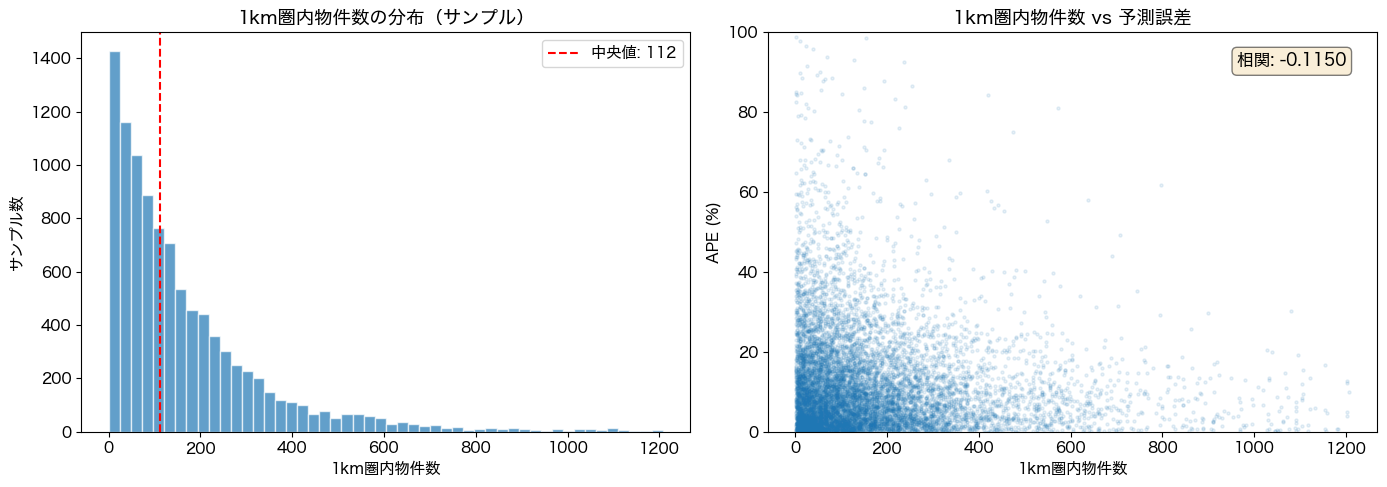

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 近傍物件数の分布
ax = axes[0]
ax.hist(nearby_1km, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(np.median(nearby_1km), color='red', linestyle='--', label=f'中央値: {np.median(nearby_1km):.0f}')
ax.set_xlabel('1km圏内物件数')
ax.set_ylabel('サンプル数')
ax.set_title('1km圏内物件数の分布（サンプル）')
ax.legend()

# 右: 近傍物件数 vs APE
ax = axes[1]
ax.scatter(nearby_1km, sample_ape, alpha=0.1, s=5)
ax.set_xlabel('1km圏内物件数')
ax.set_ylabel('APE (%)')
ax.set_title('1km圏内物件数 vs 予測誤差')
ax.set_ylim(0, 100)

# 相関
corr = np.corrcoef(np.log1p(nearby_1km), sample_ape)[0, 1]
ax.annotate(f'相関: {corr:.4f}', xy=(0.95, 0.95), xycoords='axes fraction',
           ha='right', va='top', fontsize=12, 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

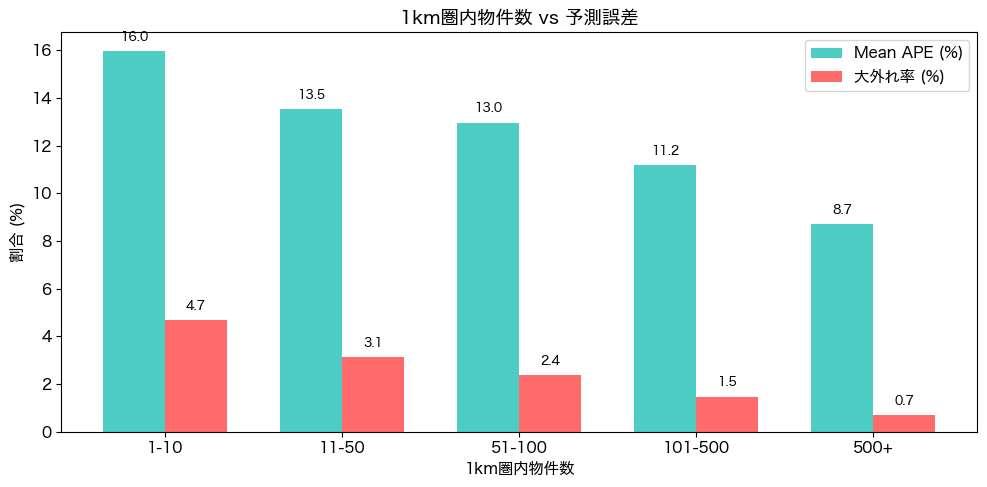


=== 1km圏内物件数 vs 予測誤差 ===
       近傍物件数 |      N |   Mean APE |       大外れ率
-------------------------------------------------------
        1-10 |    557 |      16.0% |       4.7%
       11-50 |  2,072 |      13.5% |       3.1%
      51-100 |  1,977 |      13.0% |       2.4%
     101-500 |  4,815 |      11.2% |       1.5%
        500+ |    579 |       8.7% |       0.7%


In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

# 近傍物件数で分割
bins = [0, 10, 50, 100, 500, 50000]
labels = ['1-10', '11-50', '51-100', '101-500', '500+']

nearby_stats = []
for i in range(len(bins) - 1):
    mask = (nearby_1km > bins[i]) & (nearby_1km <= bins[i+1])
    n = np.sum(mask)
    if n > 0:
        nearby_stats.append({
            'label': labels[i],
            'n': n,
            'mean_ape': np.mean(sample_ape[mask]),
            'large_rate': np.sum(sample_ape[mask] > 50) / n * 100,
        })

x = [s['label'] for s in nearby_stats]
y_ape = [s['mean_ape'] for s in nearby_stats]
y_rate = [s['large_rate'] for s in nearby_stats]

x_pos = np.arange(len(nearby_stats))
width = 0.35

bars1 = ax.bar(x_pos - width/2, y_ape, width, label='Mean APE (%)', color='#4ecdc4')
bars2 = ax.bar(x_pos + width/2, y_rate, width, label='大外れ率 (%)', color='#ff6b6b')

ax.set_xlabel('1km圏内物件数')
ax.set_ylabel('割合 (%)')
ax.set_title('1km圏内物件数 vs 予測誤差')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend()

# 値を表示
for bar, v in zip(bars1, y_ape):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{v:.1f}', ha='center', va='bottom', fontsize=9)
for bar, v in zip(bars2, y_rate):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{v:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print('\n=== 1km圏内物件数 vs 予測誤差 ===')
print(f'{"近傍物件数":>12} | {"N":>6} | {"Mean APE":>10} | {"大外れ率":>10}')
print('-' * 55)
for s in nearby_stats:
    print(f'{s["label"]:>12} | {s["n"]:>6,} | {s["mean_ape"]:>9.1f}% | {s["large_rate"]:>9.1f}%')

## 6. 相関分析

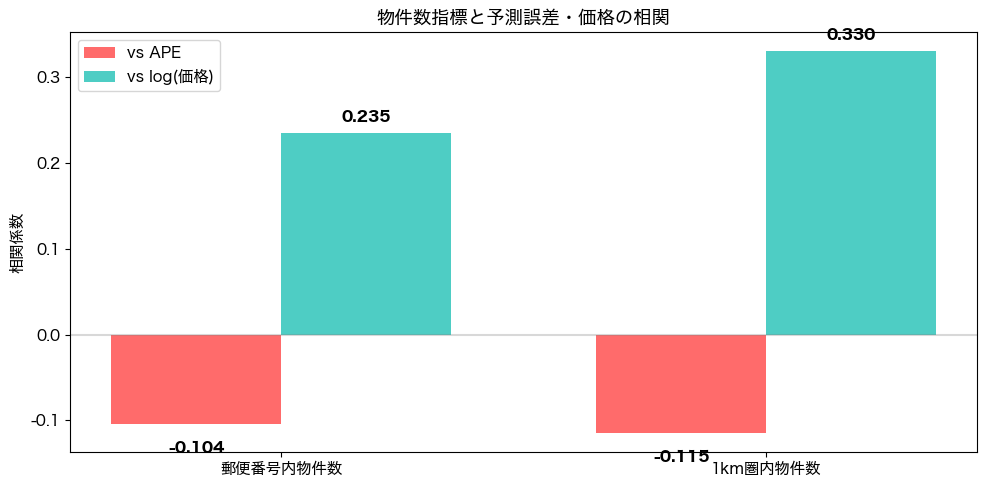


=== 相関分析 ===
                  指標 |     vs APE |      vs log(価格)
--------------------------------------------------
            郵便番号内物件数 |    -0.1042 |          0.2347
            1km圏内物件数 |    -0.1150 |          0.3303


In [9]:
# 郵便番号内物件数（全データ）
valid_mask = post_count > 0
corr_post_ape = np.corrcoef(np.log1p(post_count[valid_mask]), ape[valid_mask])[0, 1]
corr_post_price = np.corrcoef(np.log1p(post_count[valid_mask]), np.log1p(actual[valid_mask]))[0, 1]

# 1km圏内物件数（サンプル）
corr_nearby_ape = np.corrcoef(np.log1p(nearby_1km), sample_ape)[0, 1]
corr_nearby_price = np.corrcoef(np.log1p(nearby_1km), np.log1p(sample_actual))[0, 1]

fig, ax = plt.subplots(figsize=(10, 5))

metrics = ['郵便番号内物件数', '1km圏内物件数']
corr_ape = [corr_post_ape, corr_nearby_ape]
corr_price = [corr_post_price, corr_nearby_price]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, corr_ape, width, label='vs APE', color='#ff6b6b')
bars2 = ax.bar(x + width/2, corr_price, width, label='vs log(価格)', color='#4ecdc4')

ax.set_ylabel('相関係数')
ax.set_title('物件数指標と予測誤差・価格の相関')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)

# 値を表示
for bar, v in zip(bars1, corr_ape):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.02,
            f'{v:.3f}', ha='center', va='top', fontsize=11, fontweight='bold')
for bar, v in zip(bars2, corr_price):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{v:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print('\n=== 相関分析 ===')
print(f'{"指標":>20} | {"vs APE":>10} | {"vs log(価格)":>15}')
print('-' * 50)
print(f'{"郵便番号内物件数":>20} | {corr_post_ape:>10.4f} | {corr_post_price:>15.4f}')
print(f'{"1km圏内物件数":>20} | {corr_nearby_ape:>10.4f} | {corr_nearby_price:>15.4f}')

## 7. サマリー

/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_89677/3736315829.py:63: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_89677/3736315829.py:63: UserWarning: Glyph 20621 (\N{CJK UNIFIED IDEOGRAPH-508D}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_89677/3736315829.py:63: UserWarning: Glyph 29289 (\N{CJK UNIFIED IDEOGRAPH-7269}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_89677/3736315829.py:63: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/7z/w72h8bfd0318y8rm7gw9vqmc0000gp/T/ipykernel_89677/3736315829.py:63: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layo

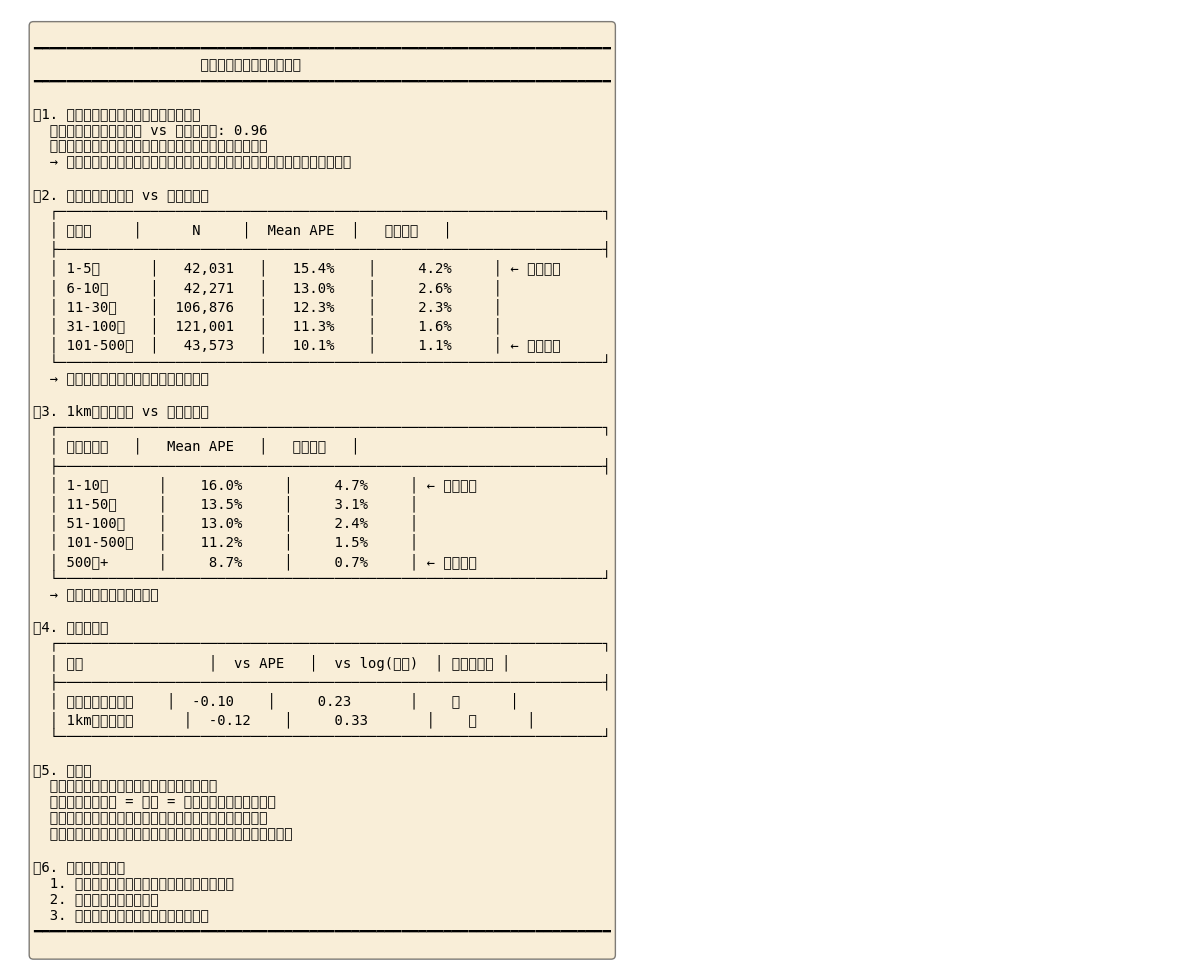

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

summary_text = """
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
                    近傍物件数の分析サマリー
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

【1. サンプル数は人口に比例している】
  ・都道府県別サンプル数 vs 人口の相関: 0.96
  ・サンプル数自体が需要（人口）の代理変数として使える
  → 別途人口データを入れなくても、学習データ自体が人口の代理になっている

【2. 郵便番号内物件数 vs 予測誤差】
  ┌─────────────────────────────────────────────────────────────────┐
  │ 物件数     │      N     │  Mean APE  │   大外れ率   │
  ├─────────────────────────────────────────────────────────────────┤
  │ 1-5件      │   42,031   │   15.4%    │     4.2%     │ ← 予測困難
  │ 6-10件     │   42,271   │   13.0%    │     2.6%     │
  │ 11-30件    │  106,876   │   12.3%    │     2.3%     │
  │ 31-100件   │  121,001   │   11.3%    │     1.6%     │
  │ 101-500件  │   43,573   │   10.1%    │     1.1%     │ ← 予測容易
  └─────────────────────────────────────────────────────────────────┘
  → 物件数が少ない地域ほど予測が難しい

【3. 1km圏内物件数 vs 予測誤差】
  ┌─────────────────────────────────────────────────────────────────┐
  │ 近傍物件数   │   Mean APE   │   大外れ率   │
  ├─────────────────────────────────────────────────────────────────┤
  │ 1-10件      │    16.0%     │     4.7%     │ ← 予測困難
  │ 11-50件     │    13.5%     │     3.1%     │
  │ 51-100件    │    13.0%     │     2.4%     │
  │ 101-500件   │    11.2%     │     1.5%     │
  │ 500件+      │     8.7%     │     0.7%     │ ← 予測容易
  └─────────────────────────────────────────────────────────────────┘
  → 同様の傾向（より強い）

【4. 相関分析】
  ┌─────────────────────────────────────────────────────────────────┐
  │ 指標               │  vs APE   │  vs log(価格)  │ 計算コスト │
  ├─────────────────────────────────────────────────────────────────┤
  │ 郵便番号内物件数    │  -0.10    │     0.23       │    低      │
  │ 1km圏内物件数      │  -0.12    │     0.33       │    高      │
  └─────────────────────────────────────────────────────────────────┘

【5. 結論】
  ・「近傍物件数」は有効な特徴量になりそう
  ・物件数が少ない = 田舎 = 価格が安い（広くても）
  ・計算コストを考慮すると「郵便番号内物件数」が現実的
  ・既存の特徴量に追加することで、大外れを減らせる可能性あり

【6. 次のステップ】
  1. 「郵便番号内物件数」を特徴量として追加
  2. 再学習して効果を確認
  3. 効果があれば「近傍物件数」も検討
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

ax.text(0.02, 0.98, summary_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()